# Deploy and Monitor a ML Workflow for Image Classification

## Introduction

The goal of this project is to build and ship an image classification model with AWS SageMaker for Scones Unlimited, a scone-delivery-focused logistic company. We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification.

**Data sources:**

The CIFAR dataset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

## Scoping: 

- Extract, Transform, and Load (ETL)
    - Extract data from a hosting service
    - Transform data into a usable shape and format
    - Load data into a production system
- Model Training
- Lambdas and Step Function Workflow
- Testing and Evaluation
- Conclusion

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import requests
import tarfile
import pickle
import jsonlines
import random
import logging

import os
import sagemaker
import boto3
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.serializers import IdentitySerializer
from sagemaker.s3 import S3Downloader
import base64

## Extract, Transform, and Load (ETL)


#### Extract data from a hosting service

In [2]:
#define function, `extract_cifar_data`, that extracts data from a hosting service
def extract_cifar_data(url, filename="cifar.tar.gz"):
    
    #request the data from the data url
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

In [3]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

#### Transform data into a usable shape and format

In [4]:
#Transform data into a usable shape and format
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

In [5]:
with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [6]:
#train dataset's keys
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [8]:
#let's transform one of our images

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

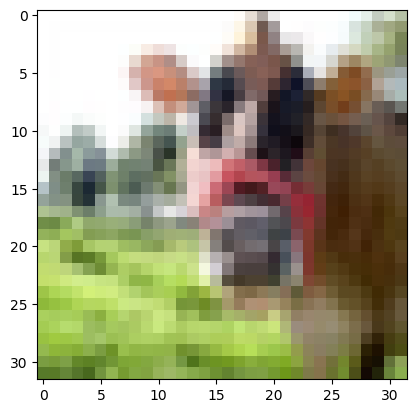

In [10]:
#show image
plt.imshow(combined)
plt.show();

In [11]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [12]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Let's check the image's file name:

In [14]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle.

In [15]:
#save image
plt.imsave("file.png", combined)

Beacuse of the size of the dataset, we will focus on bicycles and motorcycles only. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In [16]:
#Filter dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
filter_label = {}
fine_label_names = dataset_meta[b'fine_label_names']

for idx, label in enumerate(fine_label_names):
    if label == b'bicycle' or label == b'motorcycle':
        filter_label[label] = idx

In [17]:
# Label numbers for bicycle and motorcycles
print(list(filter_label.values()))

[8, 48]


Below, we drop the rows that do not contain observations about bicycles and motorcycles.

In [18]:
#Construct dataframe: df_train
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

#Drop all rows from df_train where label is not 8 or 48
df_train = df_train.loc[(df_train['labels'] == 8) | (df_train['labels'] == 48)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


#Construct dataframe: df_test
df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test.loc[(df_test['labels'] == 8) | (df_test['labels'] == 48)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [20]:
#create train and test directories
!mkdir ./train
!mkdir ./test

In [23]:
#define function, save_images, to save our images
def save_images(dataset, path, item_df):
    
    #Grab image data in row-major form
    for x in item_df['row']:
        img = dataset[b'data'][x]
    
        # Consolidated stacking/reshaping
        target = np.dstack((img[0:1024].reshape(32,32),
                        img[1024:2048].reshape(32,32),
                        img[2048:].reshape(32,32)
                        ))
    
        # Save image
        plt.imsave(path + '/' + item_df['filenames'][x], target)
    
    return 

##call function
save_images(dataset=dataset_train, path="./train", item_df=df_train)
save_images(dataset=dataset_test, path="./test", item_df=df_test)

#### Load data into a production system

Now we can load the data into S3.

In [24]:
session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-032628232841
AWS Region: us-east-1
RoleArn: arn:aws:iam::032628232841:role/service-role/AmazonSageMaker-ExecutionRole-20230511T200638


In [26]:
#sync data up into S3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000017.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000043.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000021.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000039.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000051.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000038.png
upload: train/bicycle_s_000180.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000180.png
upload: train/bicycle_s_000156.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000156.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-east-1-032628232841/train/bicycle_s_000124.png
upload: train/bicycle_s_000231.png to s3://sagemaker-us-east-1-0326282328

In [27]:
#Sagemaker expects metadata in the form of TSV files with labels and filepaths
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

In [28]:
# Upload manifest files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

## Model Training

In [29]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve("image-classification", region=region)## TODO: fill in
s3_output_location = f"s3://{bucket}/models/image_model"

In [30]:
#Create estimator: img_classifier_model
img_classifier_model=sagemaker.estimator.Estimator(image_uri=algo_image,
                                                   role=role,
                                                   instance_count=1,
                                                   instance_type='ml.p2.xlarge',
                                                   output_path=s3_output_location,
                                                   sagemaker_session=sagemaker.Session()
)

In [31]:
#set hyperparameters
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', # TODO: Fill in
    num_classes=2, # TODO: Fill in
    num_training_samples=len(df_train)# TODO: fill in
)

In [32]:
#define inputs for model
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

In [33]:
##train img_classifier_model
img_classifier_model.fit(model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2023-08-26-13-37-46-546


2023-08-26 13:37:47 Starting - Starting the training job......
2023-08-26 13:38:23 Starting - Preparing the instances for training............
2023-08-26 13:40:27 Downloading - Downloading input data...
2023-08-26 13:41:12 Training - Downloading the training image............
2023-08-26 13:43:03 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Aug 26 13:43:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|           

## Deployment

In [34]:
#configure Model Monitor to track deployment using DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

In [35]:
deployment = img_classifier_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m5.xlarge",
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-08-26-13-56-25-016
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-08-26-13-56-25-016
INFO:sagemaker:Creating endpoint with name image-classification-2023-08-26-13-56-25-016


-------!image-classification-2023-08-26-13-56-25-016


In [36]:
#instantiate predictor
predictor = sagemaker.predictor.Predictor(endpoint,
                                          sagemaker_session=sagemaker.Session(),
)

In [37]:
#Use predictor to process the `payload`
predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload, initial_args={'ContentType': 'image/png'})

In [38]:
print(inference)

b'[0.9827979207038879, 0.01720210164785385]'


A value of [0.9827979207038879, 0.01720210164785385] indicates the probability of `./test/bicycle_s_001789.png` being a bicycle is 98.28% and being a motorcycle is 0.02%.

## Lambdas and Step Function Workflow

In this stage, I will write and deploy three Lambda functions on AWS, and then use the Step Functions visual editor to chain them together! 

- The first lambda function is responsible for data generation
- The next function is responsible for classification part 
- The third function is responsible for filtering out low-confidence inferences.

Please note: the code for each lambda function have been saved in a python script called `lambda.py`

**Now let's test and evaluate!**

## Testing and Evaluation

In [39]:
# generate_test_case
def generate_test_case():
    
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-032628232841", "s3_key": "test/minibike_s_001732.png"}'

In [46]:
#path to captured data
data_path = 's3://sagemaker-us-east-1-032628232841/data_capture/image-classification-2023-08-26-13-56-25-016/AllTraffic/2023/08/26/14/'

S3Downloader.download(data_path, "captured_data")

['captured_data/00-45-676-1ff5be88-e1d0-4d22-adeb-27dff194f5d4.jsonl']

In [41]:
!pip install jsonlines

  Using cached jsonlines-3.1.0-py3-none-any.whl (8.6 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [47]:
# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [48]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.9827979207038879, 0.01720210164785385], '2023-08-26T14:00:45Z')

In [49]:
logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

%matplotlib inline

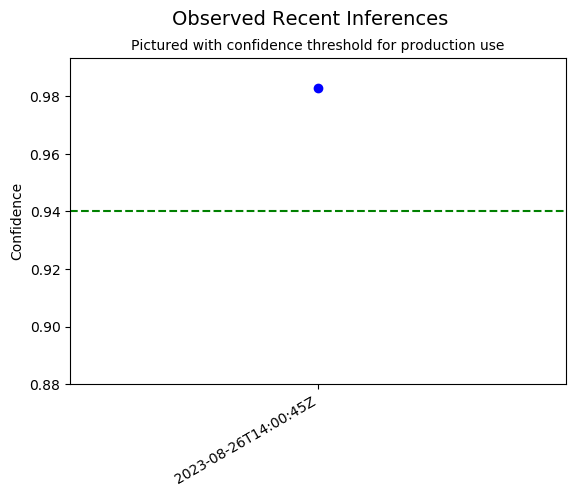

In [50]:
# Populate data for x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Plot data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

## Conclusion

In this project, I created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. I used the SageMaker Estimator API to deploy my SageMaker Model and Endpoint, and used AWS Lambda and Step Functions to orchestrate my ML workflow. Using SageMaker Model Monitor, I instrumented and observed my Endpoint, and at the end of the project I built a visualization to help stakeholders understand the performance of the Endpoint over time. 